Repo root: C:\Users\a.colonia\Documents\tesis-pinn
Input  OVF dir: C:\Users\a.colonia\Documents\tesis-pinn\data_raw\mumax\MuMax\scripts
Output dir: C:\Users\a.colonia\Documents\tesis-pinn\figs\mumax
Se encontraron 2 archivos .ovf
✅ Stats extraídos: (2, 9)


,file,path,valuedim,labels,units,mean,std,min,max
0,m000179.ovf,data_raw\mumax\MuMax\scripts\Fig3_a_b\m000179.ovf,3,m_x m_y m_z,1 1 1,1.540865e-01,0.364356,-1.0,1.0
1,Edens_anis000034.ovf,data_raw\mumax\MuMax\scripts\Fig3_i_j_k\Edens_...,1,Edens_anis,J/m3,-1.089924e+06,582036.437500,-1407110.0,0.0


CSV guardado en: C:\Users\a.colonia\Documents\tesis-pinn\figs\mumax\mumax_stats.csv


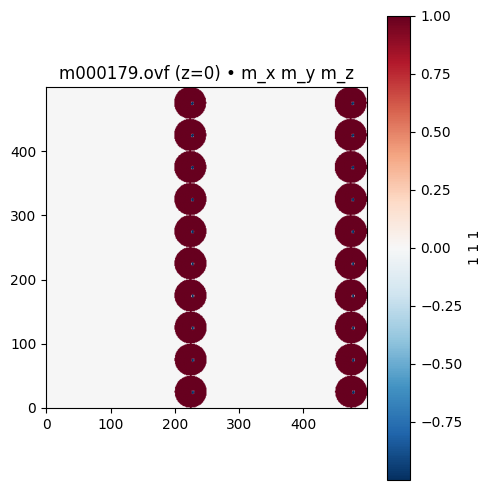

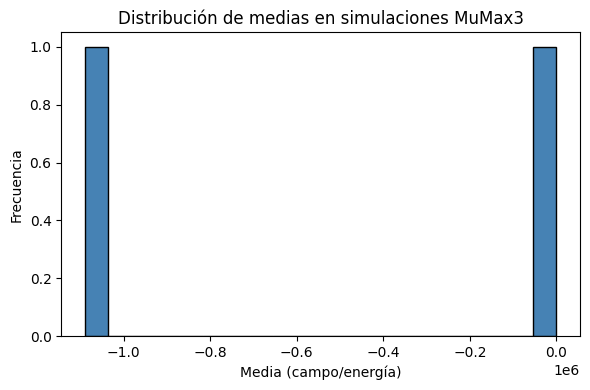

In [ ]:
# =============================================
# 06_mumax_data_integration.ipynb
# MuMax3 OVF: lectura (nativa + getOvf.py), stats y visualización
# =============================================

import sys, struct, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ RUTAS ------------------
REPO_ROOT   = Path("..").resolve()
DATA_OVF_DIR = REPO_ROOT / "data_raw" / "mumax" / "MuMax" / "scripts"
OUT_DIR     = REPO_ROOT / "figs" / "mumax"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Repo root:", REPO_ROOT)
print("Input  OVF dir:", DATA_OVF_DIR)
print("Output dir:", OUT_DIR)

# --------------- LECTOR NATIVO ---------------
def _norm(line: bytes) -> str:
    """bytes -> str, quita '#' inicial y espacios extra."""
    s = line.decode("utf-8", errors="ignore").strip()
    if s.startswith("#"):
        s = s[1:].strip()
    return s

def read_ovf_native(filepath: Path):
    """
    Lee OVF2 (Binary 4/8). Devuelve (arr, hdr).
    arr: (Nx, Ny, Nz, C)   C=3 (Mx,My,Mz) o C=1 (escalares).
    """
    hdr = {}
    with open(filepath, "rb") as f:
        while True:
            line = f.readline()
            if not line:
                raise ValueError("Fin de archivo antes de encontrar 'Begin: Data'")
            s = _norm(line)

            # formato "clave: valor"
            if ":" in s and not s.startswith("Begin: Data"):
                key, val = s.split(":", 1)
                key = key.strip().lower()
                val = val.strip()

                if key in {"xnodes", "ynodes", "znodes", "valuedim"}:
                    hdr[key] = int(val)
                elif key in {"valuemultiplier"}:
                    hdr[key] = float(val)
                elif key in {"valuelabels", "valueunits", "title", "meshtype"}:
                    hdr[key] = val
                # otros campos (xbase, ybase, etc.) no son necesarios ahora

            # detecta el inicio de datos
            if s.startswith("Begin: Data"):
                # ejemplos:
                # "Begin: Data Binary 4"
                # "Begin: Data Binary 8"
                toks = s.split()
                if len(toks) < 4 or toks[2] != "Binary":
                    raise NotImplementedError(f"Formato no soportado: '{s}'")
                precision = int(toks[3])
                break

        Nx = int(hdr.get("xnodes", 0))
        Ny = int(hdr.get("ynodes", 0))
        Nz = int(hdr.get("znodes", 0))
        valuedim = int(hdr.get("valuedim", 3))
        valm = float(hdr.get("valuemultiplier", 1.0))

        if Nx*Ny*Nz == 0:
            raise ValueError("Header incompleto: xnodes/ynodes/znodes inválidos.")

        # --- endian mark ---
        if precision == 4:
            mark = f.read(4)
            if struct.unpack(">f", mark)[0] == 1234567.0:
                dtype = ">f4"
            elif struct.unpack("<f", mark)[0] == 1234567.0:
                dtype = "<f4"
            else:
                raise ValueError("Marca endian 4B inválida.")
        elif precision == 8:
            mark = f.read(8)
            if struct.unpack(">d", mark)[0] == 123456789012345.0:
                dtype = ">f8"
            elif struct.unpack("<d", mark)[0] == 123456789012345.0:
                dtype = "<f8"
            else:
                raise ValueError("Marca endian 8B inválida.")
        else:
            raise NotImplementedError(f"Precisión no soportada: {precision}")

        # --- leer bloque binario ---
        n_vox = Nx * Ny * Nz
        expected = n_vox * valuedim
        arr = np.fromfile(f, dtype=dtype, count=expected)
        if arr.size != expected:
            raise ValueError(f"Tamaño de datos inesperado: {arr.size} vs {expected}.")

        arr = arr.reshape((Nx, Ny, Nz, valuedim)) * valm
        hdr.setdefault("valuelabels", "Mx My Mz" if valuedim == 3 else "Value")
        return arr, hdr

# ------- lector alterno (getOvf.py en src/utils) -------
sys.path.append(str(REPO_ROOT / "src" / "utils"))
try:
    from getOvf import getData as getData_from_utils
    HAS_GETOVF = True
except Exception as e:
    HAS_GETOVF = False
    warnings.warn(f"No se pudo importar getOvf.py: {e}\nUsaré solo el lector nativo.")

def read_ovf_via_getOvf(filepath: Path):
    if not HAS_GETOVF:
        raise RuntimeError("getOvf.py no disponible.")
    arr, headers, _extras = getData_from_utils(str(filepath))
    arr = np.asarray(arr)
    valuedim = arr.shape[-1] if arr.ndim == 4 else 1
    hdr = {
        "xnodes": arr.shape[0],
        "ynodes": arr.shape[1],
        "znodes": arr.shape[2] if arr.ndim >= 3 else 1,
        "valuedim": valuedim,
        "valuelabels": headers.get("valuelabels", "Value" if valuedim == 1 else "Mx My Mz"),
        "valueunits": headers.get("valueunits", "")
    }
    return arr, hdr

def load_ovf(filepath: Path):
    try:
        return read_ovf_native(filepath)
    except Exception as e_native:
        if HAS_GETOVF:
            warnings.warn(f"Lector nativo falló en '{filepath.name}': {e_native}. Intentando getOvf.py…")
            return read_ovf_via_getOvf(filepath)
        raise

# ---------------- utilidades ----------------
def find_ovf_files(root: Path):
    return sorted(root.rglob("*.ovf"))

def scalar_or_mz(arr, hdr):
    C = int(hdr.get("valuedim", arr.shape[-1]))
    if C == 1:
        return arr[..., 0]
    elif C >= 3:
        return arr[..., 2]  # Mz
    return arr[..., 0]

def basic_stats(x: np.ndarray):
    return dict(mean=float(np.mean(x)), std=float(np.std(x)),
                min=float(np.min(x)),  max=float(np.max(x)))

def plot_slice(img2d, title="", cmap="viridis", units=""):
    plt.figure(figsize=(5,5))
    plt.imshow(img2d.T, cmap=cmap, origin="lower")
    cb = plt.colorbar()
    if units: cb.set_label(units)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ----------------- pipeline -----------------
ovf_files = find_ovf_files(DATA_OVF_DIR)
print(f"Se encontraron {len(ovf_files)} archivos .ovf")

records, errores = [], []

for f in ovf_files:
    try:
        arr, hdr = load_ovf(f)
        field = scalar_or_mz(arr, hdr)
        if field.ndim == 3 and field.shape[2] >= 1:
            field2d = field[:, :, 0]
        else:
            field2d = field

        st = basic_stats(field)
        st.update({
            "file": f.name,
            "path": str(f.relative_to(REPO_ROOT)),
            "valuedim": int(hdr.get("valuedim", field.shape[-1] if field.ndim==3 else 1)),
            "labels": hdr.get("valuelabels", ""),
            "units": hdr.get("valueunits", "")
        })
        records.append(st)

    except Exception as e:
        errores.append((f.name, str(e)))
        print(f"⚠️  Error leyendo {f.name}: {e}")

df_stats = pd.DataFrame(records, columns=["file","path","valuedim","labels","units","mean","std","min","max"])
print("✅ Stats extraídos:", df_stats.shape)
display(df_stats.head(10))

csv_path = OUT_DIR / "mumax_stats.csv"
df_stats.to_csv(csv_path, index=False)
print("CSV guardado en:", csv_path)

if errores:
    print("\nArchivos con error:")
    for name, msg in errores:
        print(" -", name, "->", msg)

# ------ visualización rápida de un archivo válido ------
good = [p for p in ovf_files if p.name in set(df_stats["file"])]
if good:
    demo = good[0]
    arr, hdr = load_ovf(demo)
    field = scalar_or_mz(arr, hdr)
    img2d = field[:, :, 0] if field.ndim == 3 else field
    cmap = "RdBu_r" if int(hdr.get("valuedim", 1)) >= 3 else "viridis"
    plot_slice(img2d, title=f"{demo.name} (z=0) • {hdr.get('valuelabels','')}",
               cmap=cmap, units=hdr.get("valueunits",""))

# ------ histograma de medias ------
if not df_stats.empty:
    plt.figure(figsize=(6,4))
    plt.hist(df_stats["mean"], bins=20, color="steelblue", edgecolor="k")
    plt.xlabel("Media (campo/energía)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de medias en simulaciones MuMax3")
    plt.tight_layout()
    plt.show()


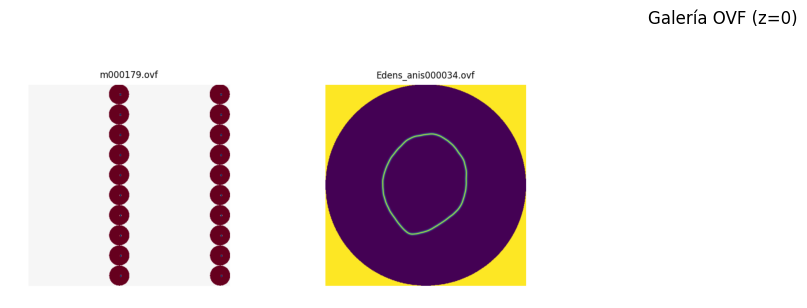

In [19]:
from math import ceil
import matplotlib.pyplot as plt

thumb_dir = OUT_DIR / "thumbs"
thumb_dir.mkdir(exist_ok=True)

def ovf_to_thumbnail(path: Path, zslice=0):
    arr, hdr = load_ovf(path)
    field = scalar_or_mz(arr, hdr)
    img = field[:, :, zslice] if field.ndim==3 else field
    cmap = "RdBu_r" if int(hdr.get("valuedim",1))>=3 else "viridis"
    plt.figure(figsize=(3,3))
    plt.imshow(img.T, cmap=cmap, origin="lower")
    plt.axis("off")
    plt.title(path.name, fontsize=8)
    plt.tight_layout()
    out = thumb_dir / f"{path.stem}.png"
    plt.savefig(out, dpi=150)
    plt.close()
    return out

thumbs = []
for p in ovf_files:
    try:
        thumbs.append(ovf_to_thumbnail(p))
    except Exception as e:
        print("⚠️", p.name, "->", e)

# mosaico
cols = 5
rows = ceil(len(thumbs)/cols) or 1
plt.figure(figsize=(3*cols, 3*rows))
for i, png in enumerate(thumbs):
    img = plt.imread(png)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("Galería OVF (z=0)", y=1.01)
plt.tight_layout()
plt.show()


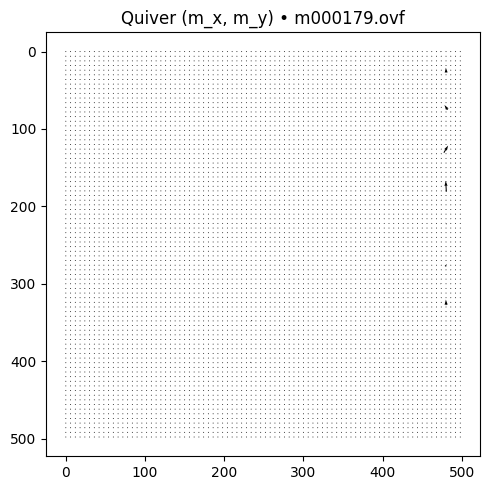

In [20]:
def plot_quiver_xy(path: Path, step=4, zslice=0):
    arr, hdr = load_ovf(path)
    if int(hdr.get("valuedim",1)) < 3:
        print("No hay m_x/m_y en", path.name)
        return
    mx = arr[:, :, zslice, 0]
    my = arr[:, :, zslice, 1]
    X, Y = np.meshgrid(np.arange(mx.shape[0]), np.arange(mx.shape[1]), indexing="ij")
    plt.figure(figsize=(5,5))
    plt.quiver(X[::step,::step], Y[::step,::step],
               mx[::step,::step], my[::step,::step], pivot="mid", scale=40)
    plt.gca().invert_yaxis()
    plt.title(f"Quiver (m_x, m_y) • {path.name}")
    plt.tight_layout()
    plt.show()

# ejemplo con el de magnetización
for p in ovf_files:
    if "m000" in p.name:
        plot_quiver_xy(p, step=6)


In [ ]:
from scipy.stats import entropy

def extra_metrics(field2d):
    f_up   = np.mean(field2d >  0.5)
    f_down = np.mean(field2d < -0.5)
    mean_abs = float(np.mean(np.abs(field2d)))
    # hist para entropía (normalizado)
    hist, _ = np.histogram(field2d, bins=64, range=(-1,1), density=True)
    hist = hist + 1e-12
    ent = float(entropy(hist))
    return dict(frac_up=f_up, frac_down=f_down, mean_abs=mean_abs, entropy=ent)

adv_records = []
for f in ovf_files:
    try:
        arr, hdr = load_ovf(f)
        field = scalar_or_mz(arr, hdr)
        img = field[:, :, 0] if field.ndim==3 else field
        adv = extra_metrics(img)
        adv["file"] = f.name
        adv_records.append(adv)
    except Exception as e:
        print("!", f.name, "->", e)

df_adv = pd.DataFrame(adv_records)
display(df_adv.head())

df_full = df_stats.merge(df_adv, on="file", how="left")
df_full.to_csv(OUT_DIR / "mumax_stats_plus.csv", index=False)
print("Guardado:", OUT_DIR / "mumax_stats_plus.csv")


,frac_up,frac_down,mean_abs,entropy,file
0,0.155352,0.001320,1.565550e-01,0.451040,m000179.ovf
1,0.000000,0.784472,1.089924e+06,0.000662,Edens_anis000034.ovf


Guardado: C:\Users\a.colonia\Documents\tesis-pinn\figs\mumax\mumax_stats_plus.csv


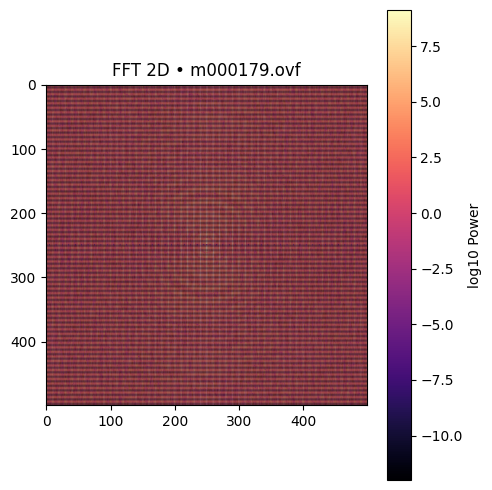

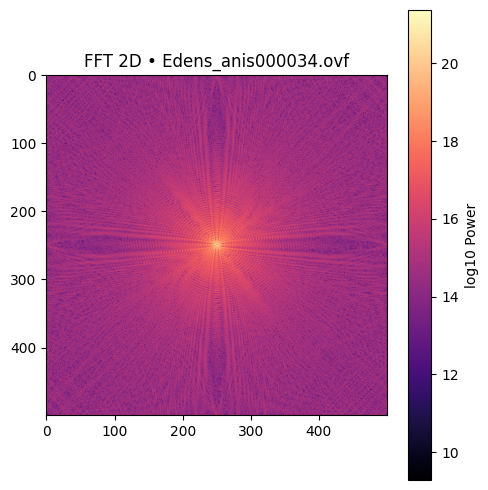

In [22]:
def plot_fft2(field2d, title=""):
    f = np.fft.fftshift(np.fft.fft2(field2d - field2d.mean()))
    power = np.log10(1e-12 + np.abs(f)**2)
    plt.figure(figsize=(5,5))
    plt.imshow(power, cmap="magma")
    plt.colorbar(label="log10 Power")
    plt.title(f"FFT 2D • {title}")
    plt.tight_layout()
    plt.show()

# ejemplo
for p in ovf_files:
    arr, hdr = load_ovf(p)
    field = scalar_or_mz(arr, hdr)
    img = field[:, :, 0] if field.ndim==3 else field
    plot_fft2(img, p.name)


In [23]:
import re

def parse_param_from_name(name, key=r"dMI_(\d+\.?\d*)"):
    m = re.search(key, name)
    return float(m.group(1)) if m else np.nan

tmp = []
for p in ovf_files:
    tmp.append({"file": p.name,
                "dmi_from_name": parse_param_from_name(p.name, r"dMI_(\d+\.?\d*)")})
df_name_params = pd.DataFrame(tmp)
display(df_name_params.head())

df_merged = df_full.merge(df_name_params, on="file", how="left")
df_merged.to_csv(OUT_DIR/"mumax_stats_named.csv", index=False)


,file,dmi_from_name
0,m000179.ovf,NaN
1,Edens_anis000034.ovf,NaN


In [ ]:
import re
def parse_many(name: str):
    def g(rx):
        m=re.search(rx, name, re.I);
        return float(m.group(1)) if m else np.nan
    return dict(
        dmi   = g(r"(?:^|_)dmi[_-]?(\d+\.?\de?-?\d*)"),
        ku    = g(r"(?:^|_)ku[_-]?(\d+\.?\de?-?\d*)"),
        aex   = g(r"(?:^|_)aex[_-]?(\d+\.?\de?-?\d*)"),
        ms    = g(r"(?:^|_)ms[_-]?(\d+\.?\de?-?\d*)"),
        alpha = g(r"(?:^|_)alpha[_-]?(\d+\.?\de?-?\d*)"),
    )

df_name = pd.DataFrame([{"file":p.name, **parse_many(p.name)} for p in ovf_files])
df_merged = df_full.merge(df_name, on="file", how="left")
df_merged.to_csv(OUT_DIR/"mumax_stats_enriched.csv", index=False)


In [ ]:
def get_component(arr, hdr, comp="mz", z=0):
    C = int(hdr.get("valuedim", arr.shape[-1]))
    if C==1:
        return arr[...,0] if arr.ndim==3 else arr
    idx = dict(mx=0,my=1,mz=2)[comp]
    return arr[:,:,z,idx]


In [26]:
def plot_fft2_win(img2d, title=""):
    win = np.hanning(img2d.shape[0])[:,None] * np.hanning(img2d.shape[1])[None,:]
    f = np.fft.fftshift(np.fft.fft2((img2d - img2d.mean())*win))
    power = np.log10(1e-12 + np.abs(f)**2)
    plt.figure(figsize=(5,5)); plt.imshow(power, cmap="magma"); plt.colorbar(label="log10 Power")
    plt.title(f"FFT 2D (Hann) • {title}"); plt.tight_layout(); plt.show()
